In [40]:
import sys
import importlib
sys.path.insert(1, r'C:\Users\alyahyma\Projects\NBA_API\codes')

# Import the module
from my_functions import NBA_functions
from my_functions import plotting_functions

# Reload the module (note how we pass the module object directly)
importlib.reload(NBA_functions)
importlib.reload(plotting_functions)

# Now you can use your imported functions
from my_functions.NBA_functions import team_log
from my_functions.NBA_functions import get_team_abbreviation
from my_functions.plotting_functions import set_fig_style


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy import stats
from datetime import date
import requests
import matplotlib as mpl

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from nba_api.stats.endpoints import leaguegamefinder, teamgamelog, boxscoreadvancedv2
from nba_api.stats.static import teams, players
from nba_api.live.nba.endpoints import scoreboard

import seaborn as sns


In [16]:
team_conf_info = {
    "Atlanta Hawks"         : ("East", "Southeast"),
    "Boston Celtics"        : ("East", "Atlantic"),
    "Brooklyn Nets"         : ("East", "Atlantic"),
    "Charlotte Hornets"     : ("East", "Southeast"),
    "Chicago Bulls"         : ("East", "Central"),
    "Cleveland Cavaliers"   : ("East", "Central"),
    "Dallas Mavericks"      : ("West", "Southwest"),
    "Denver Nuggets"        : ("West", "Northwest"),
    "Detroit Pistons"       : ("East", "Central"),
    "Golden State Warriors" : ("West", "Pacific"),
    "Houston Rockets"       : ("West", "Southwest"),
    "Indiana Pacers"        : ("East", "Central"),
    "LA Clippers"           : ("West", "Pacific"),
    "Los Angeles Lakers"    : ("West", "Pacific"),
    "Memphis Grizzlies"     : ("West", "Southwest"),
    "Miami Heat"            : ("East", "Southeast"),
    "Milwaukee Bucks"       : ("East", "Central"),
    "Minnesota Timberwolves": ("West", "Northwest"),
    "New Orleans Pelicans"  : ("West", "Southwest"),
    "New York Knicks"       : ("East", "Atlantic"),
    "Oklahoma City Thunder" : ("West", "Northwest"),
    "Orlando Magic"         : ("East", "Southeast"),
    "Philadelphia 76ers"    : ("East", "Atlantic"),
    "Phoenix Suns"          : ("West", "Pacific"),
    "Portland Trail Blazers": ("West", "Northwest"),
    "Sacramento Kings"      : ("West", "Pacific"),
    "San Antonio Spurs"     : ("West", "Southwest"),
    "Toronto Raptors"       : ("East", "Atlantic"),
    "Utah Jazz"             : ("West", "Northwest"),
    "Washington Wizards"    : ("East", "Southeast")
}

In [6]:
all_teams = teams.get_teams()  
team_info = random.choice(all_teams) 


In [7]:
# example for logistic regression
OKC_team_log = team_log_by_abbrev('OKC')

X = OKC_team_log[['FG3A']].values.reshape(-1, 1)  # Predictor
y = (OKC_team_log['WL'] == 'W').astype(int).values  # Convert 'W' and 'L' to 1 and 0, respectively

model = LogisticRegression().fit(X, y)
print(f"Coefficient: {model.coef_[0]}, Intercept: {model.intercept_}")

# example for linear regression 
X = OKC_team_log[['FG3A']].values.reshape(-1, 1)  # Predictor
y = OKC_team_log['PTS'].astype(int).values  # Predicted

model = LinearRegression().fit(X, y)
print(f"Coefficient: {model.coef_[0]}, Intercept: {model.intercept_}")


Coefficient: [-0.02401528], Intercept: [2.49685262]
Coefficient: 0.6404528009577125, Intercept: 94.49728295952022


In [17]:
def clean_up_to_date_season_stats():
    
    """
    
    Fetches up to NBA season stat df, remove unnessary col such as season_ID, game_ID etc
    also add recorfs within cnf, within division, conf rank, league rank.
    
    """
    
    # Retrieve the games data for the season
    gamefinder = leaguegamefinder.LeagueGameFinder(season_nullable='2024-25', league_id_nullable='00')
    games_df = gamefinder.get_data_frames()[0]
    
    # Filter necessary games and teams to reduce data size
    games_df = games_df[games_df['SEASON_ID'] == '22024']
    nba_teams = games_df['TEAM_NAME'].value_counts().index[:30]
    
    games_df = games_df[games_df['TEAM_NAME'].isin(nba_teams)]

        
    # Merge with team configuration data
    team_conf_df = pd.DataFrame.from_dict(team_conf_info, orient='index', columns=['team_conf', 'team_div']).reset_index()
    team_conf_df.rename(columns={'index': 'TEAM_NAME'}, inplace=True)
    games_df = games_df.merge(team_conf_df, on='TEAM_NAME', how='left')
    
    # Calculate mean statistics and win-loss percentage
    season_stats = games_df.groupby('TEAM_NAME').mean(numeric_only=True)
    season_stats.drop(['TEAM_ID', 'MIN'], axis=1, inplace=True)
    season_df = season_stats.merge(team_conf_df, on='TEAM_NAME', how='left')
    
    # Win/Loss counts and percentage
    win_loss_counts = games_df.groupby('TEAM_NAME')['WL'].value_counts().unstack(fill_value=0)
    win_loss_counts['WL_PCT'] = win_loss_counts['W'] / (win_loss_counts['W'] + win_loss_counts['L'])
    season_df = season_df.merge(win_loss_counts[['WL_PCT']], on='TEAM_NAME', how='left')
    
    # Adjust matchups and calculate win percentages against conference and division
    games_df['opponent'] = games_df['MATCHUP'].str[-3:]
    games_df['opponent_conf'] = games_df['opponent'].map(games_df.set_index("TEAM_ABBREVIATION")["team_conf"].to_dict())
    games_df['opponent_div'] = games_df['opponent'].map(games_df.set_index("TEAM_ABBREVIATION")["team_div"].to_dict())
    
    # Define function to calculate percentage
    def calculate_pct(df, group_field):
        counts = df.groupby(group_field)["WL"].value_counts().unstack(fill_value=0)
        counts['WL_PCT'] = counts['W'] / (counts['W'] + counts['L'])
        return counts[['WL_PCT']]
    
    # Merge conference and division win percentages
    conf_pct = calculate_pct(games_df[games_df['team_conf'] == games_df['opponent_conf']], 'TEAM_NAME')
    div_pct = calculate_pct(games_df[games_df['team_div'] == games_df['opponent_div']], 'TEAM_NAME')
    season_df = season_df.merge(conf_pct, on='TEAM_NAME', how='left', suffixes=('', '_conf'))
    season_df = season_df.merge(div_pct, on='TEAM_NAME', how='left', suffixes=('', '_div'))
    
    # Home and away win percentages
    games_df['home_away'] = games_df['MATCHUP'].apply(lambda x: 'home' if 'vs.' in x else 'away')
    home_pct = calculate_pct(games_df[games_df['home_away'] == 'home'], 'TEAM_NAME')
    away_pct = calculate_pct(games_df[games_df['home_away'] == 'away'], 'TEAM_NAME')
    season_df = season_df.merge(home_pct, on='TEAM_NAME', how='left', suffixes=('', '_home'))
    season_df = season_df.merge(away_pct, on='TEAM_NAME', how='left', suffixes=('', '_away'))
    
    # Calculate standings
    season_df['league_standing'] = season_df['WL_PCT'].rank(method='dense', ascending=False).astype(int)
    season_df['conference_standing'] = season_df.groupby('team_conf')['WL_PCT_conf'].rank(method='dense', ascending=False).astype(int)
    
    return season_df, games_df


In [18]:
season_df,games_df = clean_up_to_date_season_stats()
season_df ['WL_cat'] = season_df['WL_PCT'].apply(lambda x: 'above .500' if x>0.5 else 'below .500')


In [21]:
def player_season_stat(full_name = 'Kobe Bryant'):
    """
    Fetches player stat

    Parameters:
    -----------
    first_name: str
        Player first name (e.g., 'LeBron' for LeBron James).
    

    Returns:
    --------
    pd.DataFrame:
        A Pandas DataFrame containing player career stats.

    Example:
    --------
    >>> df = player_season_stat(full_name = 'Kobe Bryant')
    
    """
    nba_players = players.get_players()
    player_info = [player for player in nba_players if player['full_name'] == full_name][0]
    gamefinder = leaguegamefinder.LeagueGameFinder(player_id_nullable = player_info['id'])
    games_stats = gamefinder.get_data_frames()[0]
    
    return games_stats


In [112]:
# season id explained: 
#12010 preseason 2010
#22010 regular season 2010
#32010 all star 2010
#42010 post season 2010

kobe_df = kobe_df[(kobe_df['SEASON_ID'].str[0] == '2') | \
                  (kobe_df['SEASON_ID'].str[0] == '4') ]    # filter for reg and post season

kobe_reg_season_df = kobe_df[(kobe_df['SEASON_ID'].str[0] == '2')]
kobe_post_season_df = kobe_df[(kobe_df['SEASON_ID'].str[0] == '4')]



In [12]:
kobe_df['season']      = kobe_df['SEASON_ID'].str[1:5]


kobe_df['post_season'] = kobe_df['SEASON_ID'].apply(lambda x: True if x[0] == '4' else False)


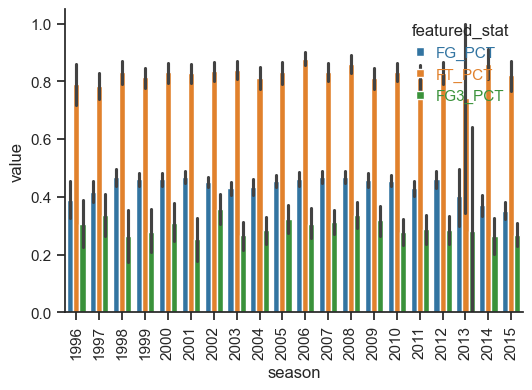

In [145]:
FG_melt =   kobe_df.melt(id_vars    = ['season','post_season'],
                         value_vars = ['FT_PCT','FG3_PCT','FG_PCT'],
                         var_name   = 'featured_stat',
                         value_name = 'value')

set_fig_style(
    figsize_mm = (150, 100),
    font_scale = 1.0,
    style      = 'ticks',
    context    = 'notebook',
)


sns.barplot(data    = FG_melt.sort_values(by='season', ascending = True),
            x       = 'season', 
            y       = 'value', 
            hue     = 'featured_stat',
            palette = 'tab10')

sns.despine()
plt.xticks(FG_melt['season'].unique()[::1], 
           rotation='vertical')

plt.show()

PTS


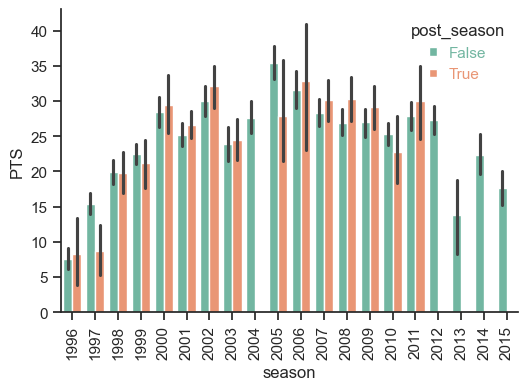

FGM


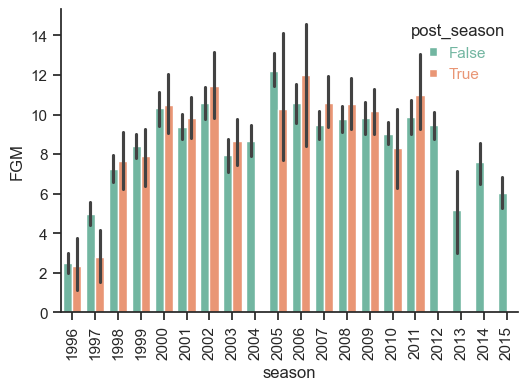

FGA


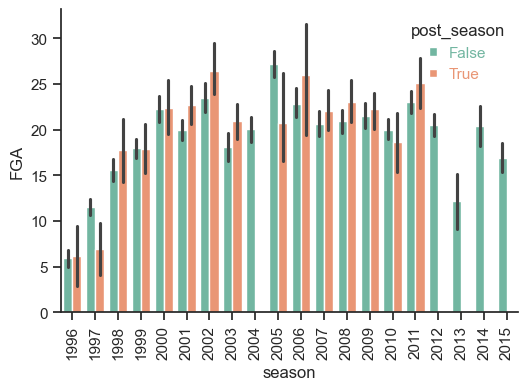

FG_PCT


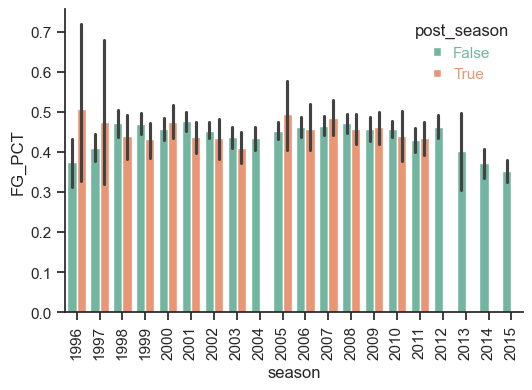

FG3M


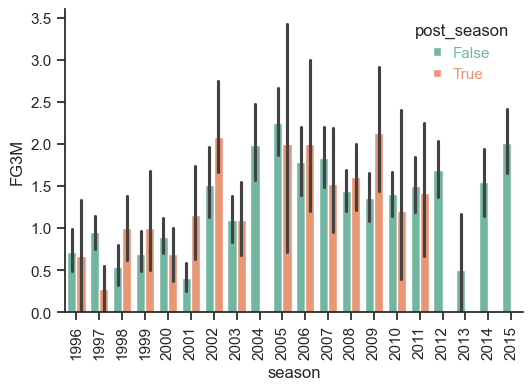

FG3A


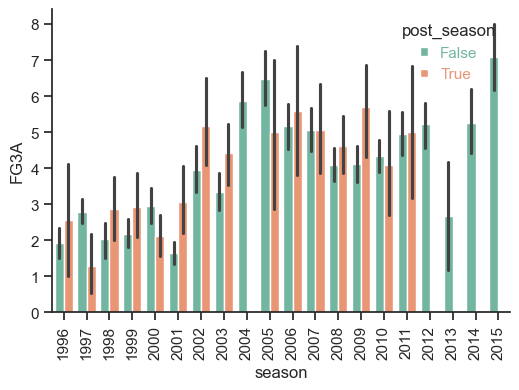

FG3_PCT


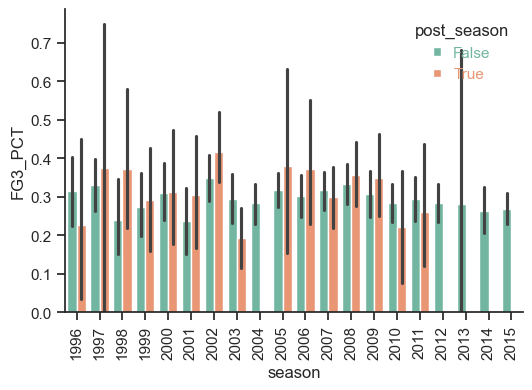

FTM


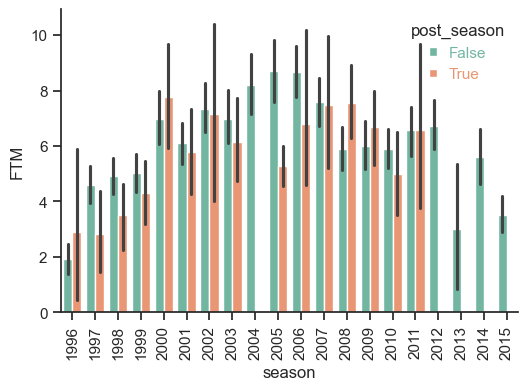

FTA


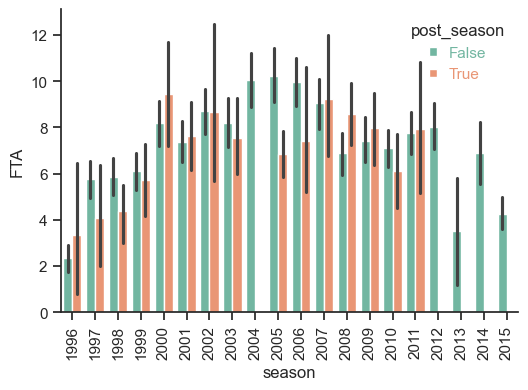

FT_PCT


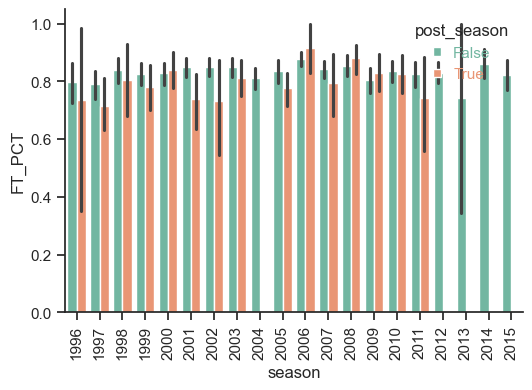

OREB


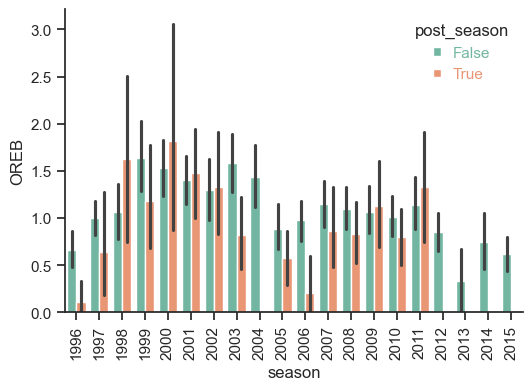

DREB


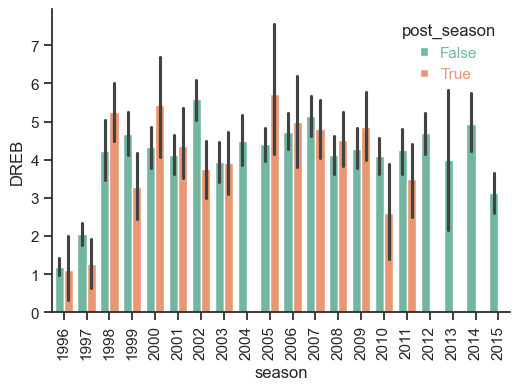

REB


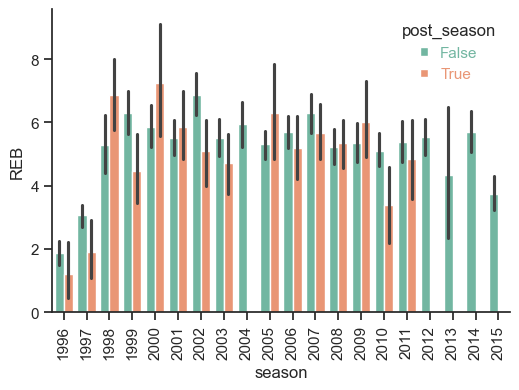

AST


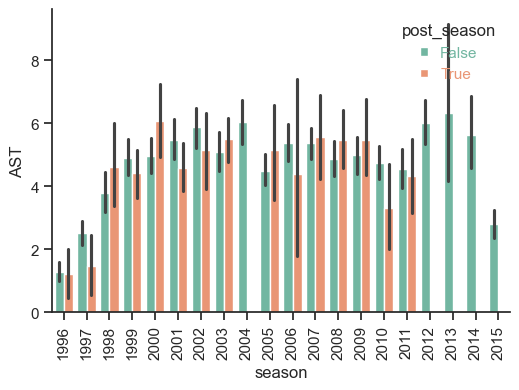

STL


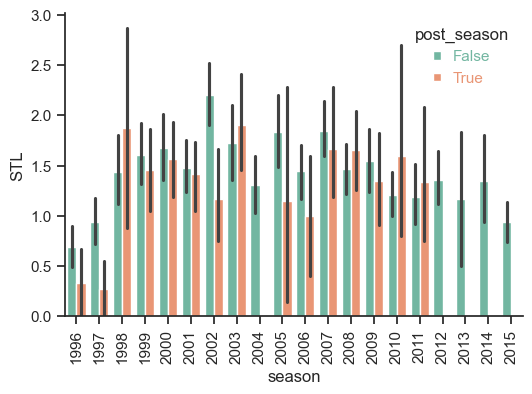

BLK


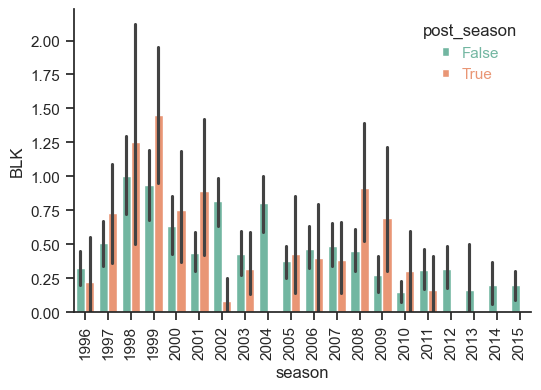

TOV


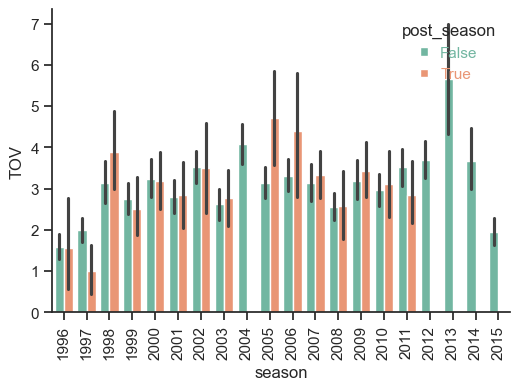

PF


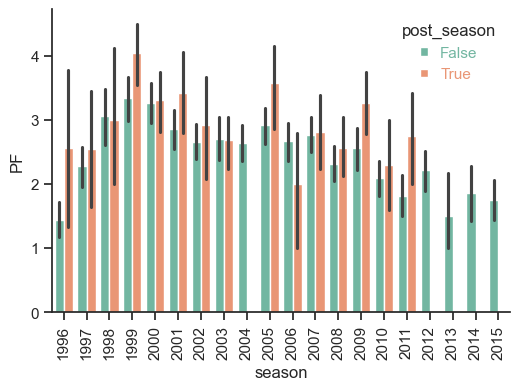

PLUS_MINUS


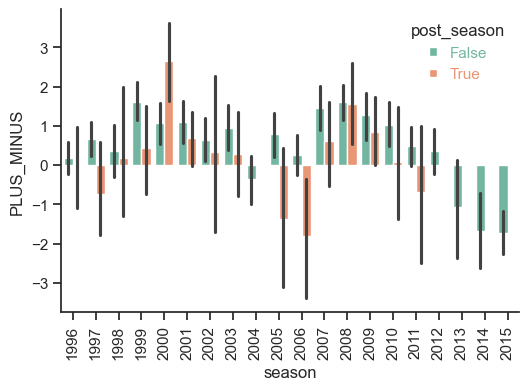

In [155]:
plot_cols = ['PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS']

for col in plot_cols:
    print(col)
    
    if np.issubdtype(kobe_df['PLUS_MINUS'].dtype, np.number) == True:
        
        sns.barplot(data    = kobe_df.sort_values(by='season', ascending = True),
                    x       = 'season', 
                    y       =  col, 
                    hue     = 'post_season',
                    palette = 'Set2')

        sns.despine()
        plt.xticks(FG_melt['season'].unique()[::1], 
                   rotation='vertical')

        plt.show()

In [151]:
np.issubdtype(kobe_df['PLUS_MINUS'].dtype, np.number)

True

In [154]:
kobe_df.columns

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'season',
       'post_season'],
      dtype='object')

In [ ]:
X = OKC_team_log[['FG3A']].values.reshape(-1, 1)  # Predictor
y = OKC_team_log['PTS'].astype(int).values  # Predicted

model = LinearRegression().fit(X, y)
print(f"Coefficient: {model.coef_[0]}, Intercept: {model.intercept_}")



In [195]:
#season_df
denver_df = games_df[games_df['TEAM_ABBREVIATION'] == 'DEN']
denver_df.columns

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'team_conf',
       'team_div', 'opponent', 'opponent_conf', 'opponent_div', 'home_away'],
      dtype='object')

In [196]:
X = denver_df[['FTA']].values.reshape(-1, 1)  # Predictor
y = denver_df['PTS'].astype(int).values  # Predicted

model = LinearRegression().fit(X, y)
print(f"Coefficient: {model.coef_[0]}, Intercept: {model.intercept_}")

Coefficient: 0.5147216323515835, Intercept: 109.76061305511956


In [235]:
teams_denver_lost_to = denver_df[denver_df['WL'] == 'L']['opponent']

name_of_teams_denver_lost_to = teams_denver_lost_to.map(team_mapping).unique()


In [250]:
teams_denver_lost_to_df = season_df[season_df['TEAM_NAME'].isin(name_of_teams_denver_lost_to)]
teams_denver_lost_to_df.columns

Index(['TEAM_NAME', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
       'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PLUS_MINUS', 'team_conf', 'team_div', 'WL_PCT',
       'WL_PCT_conf', 'WL_PCT_div', 'WL_PCT_home', 'WL_PCT_away',
       'league_standing', 'conference_standing'],
      dtype='object')

In [257]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import os

# Set OMP_NUM_THREADS to avoid potential memory leak on Windows
os.environ['OMP_NUM_THREADS'] = '1'

# Assuming teams_denver_lost_to_df is your DataFrame and already loaded
# Selecting numeric columns
numeric_cols = teams_denver_lost_to_df.select_dtypes(include=[np.number])

# Scaling the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_cols)

# Apply K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_data)  # Use fit_predict to fit and assign clusters in one step

# Add cluster labels to the DataFrame safely using .loc
teams_denver_lost_to_df.loc[:, 'Cluster'] = clusters  # Using .loc to avoid SettingWithCopyWarning




              TEAM_NAME         PTS        FGM        FGA    FG_PCT  \
1        Boston Celtics  117.047619  41.682540  90.238095  0.462968   
4         Chicago Bulls  116.603175  42.682540  92.111111  0.464476   
5   Cleveland Cavaliers  123.063492  44.777778  90.412698  0.495683   
6      Dallas Mavericks  114.500000  41.875000  88.593750  0.473844   
10      Houston Rockets  112.634921  41.746032  93.174603  0.448841   

         FG3M       FG3A   FG3_PCT        FTM        FTA  ...  team_conf  \
1   17.873016  48.095238  0.373286  15.809524  19.793651  ...       East   
4   15.777778  43.063492  0.367032  15.460317  19.238095  ...       East   
5   16.126984  41.095238  0.393730  17.380952  22.000000  ...       East   
6   13.062500  35.500000  0.367563  17.687500  22.828125  ...       West   
10  12.111111  35.301587  0.341762  17.031746  23.031746  ...       West   

     team_div    WL_PCT  WL_PCT_conf  WL_PCT_div  WL_PCT_home  WL_PCT_away  \
1    Atlantic  0.714286     0.744186  

C:\Users\alyahyma\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\alyahyma\AppData\Local\Temp\ipykernel_4684\755116699.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teams_denver_lost_to_df.loc[:, 'Cluster'] = clusters  # Using .loc to avoid SettingWithCopyWarning


In [263]:
teams_denver_lost_to_df[teams_denver_lost_to_df['Cluster'] == 1]

,TEAM_NAME,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,...,team_conf,team_div,WL_PCT,WL_PCT_conf,WL_PCT_div,WL_PCT_home,WL_PCT_away,league_standing,conference_standing,Cluster
10,Houston Rockets,112.634921,41.746032,93.174603,0.448841,12.111111,35.301587,0.341762,17.031746,23.031746,...,West,Southwest,0.603175,0.589744,0.785714,0.666667,0.545455,8,4,1
18,New Orleans Pelicans,110.793651,40.793651,90.698413,0.449683,12.174603,35.158730,0.344238,17.031746,22.396825,...,West,Southwest,0.269841,0.268293,0.230769,0.354839,0.187500,24,14,1
24,Portland Trail Blazers,110.437500,40.421875,89.234375,0.455219,12.500000,36.312500,0.346094,17.093750,22.218750,...,West,Northwest,0.437500,0.340909,0.357143,0.533333,0.352941,19,13,1
26,San Antonio Spurs,113.229508,41.540984,89.868852,0.462852,13.836066,39.622951,0.350000,16.311475,21.065574,...,West,Southwest,0.426230,0.428571,0.214286,0.517241,0.343750,20,12,1
29,Washington Wizards,108.344262,39.459016,89.786885,0.440049,12.983607,38.885246,0.331148,16.442623,21.049180,...,East,Southeast,0.196721,0.257143,0.500000,0.218750,0.172414,27,14,1


In [265]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Assuming your DataFrame and scaling is set up as before
scaler = StandardScaler()
scaled_data = scaler.fit_transform(teams_denver_lost_to_df.select_dtypes(include=[np.number]))

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_data)

# Centroids of the clusters
centroids = kmeans.cluster_centers_

# Creating a DataFrame for easier interpretation of centroids
centroid_df = pd.DataFrame(centroids, columns=teams_denver_lost_to_df.select_dtypes(include=[np.number]).columns)
centroid_df


C:\Users\alyahyma\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,PF,PLUS_MINUS,WL_PCT,WL_PCT_conf,WL_PCT_div,WL_PCT_home,WL_PCT_away,league_standing,conference_standing,Cluster
0,0.133194,0.069481,-0.643817,0.612202,-0.201453,-0.469149,0.433350,0.720567,0.562863,0.070815,...,-0.147033,0.142162,0.162220,0.226459,0.305172,0.279603,0.018806,-0.270232,-0.261932,-1.005970
1,-0.979080,-0.757373,0.347527,-1.167337,-0.774561,-0.375163,-1.210958,-0.298910,0.139469,-0.857860,...,0.275661,-0.911790,-0.915685,-1.034470,-0.777486,-0.785189,-0.939517,0.915700,0.955574,0.232147
2,0.990760,0.825125,0.692271,0.387818,1.320744,1.289965,0.755335,-0.887354,-1.159346,0.948399,...,-0.087269,0.890954,0.860722,0.896783,0.437807,0.492181,1.141485,-0.671720,-0.736087,1.470264


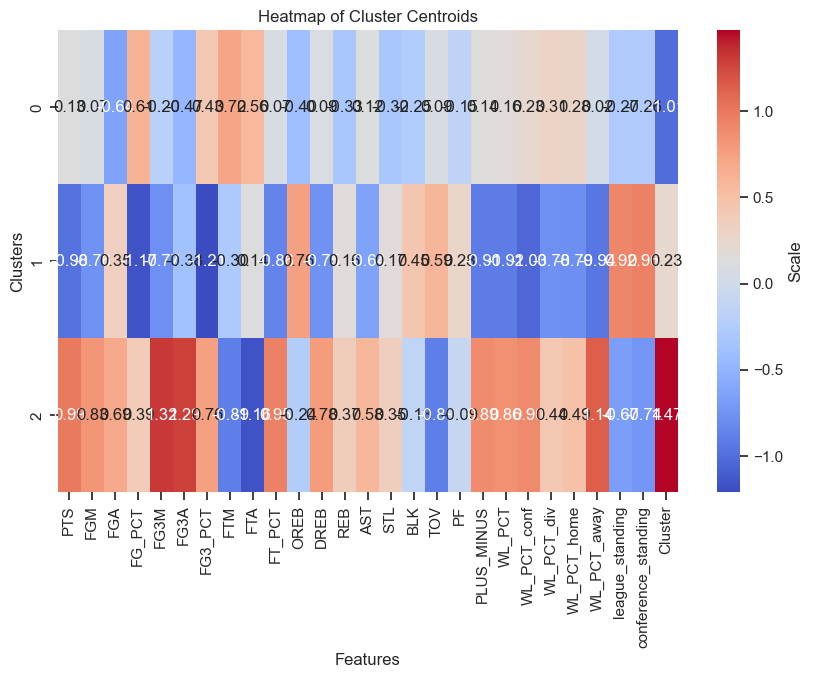

In [267]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import parallel_coordinates

# Extract centroids
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns=teams_denver_lost_to_df.select_dtypes(include=[np.number]).columns)

# Heatmap of the centroids
plt.figure(figsize=(10, 6))
sns.heatmap(centroid_df, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Scale'})
plt.title('Heatmap of Cluster Centroids')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()


In [22]:
team_mapping = {
    'Atlanta Hawks': 'ATL',
    'Boston Celtics': 'BOS',
    'Brooklyn Nets': 'BKN',
    'Charlotte Hornets': 'CHA',
    'Chicago Bulls': 'CHI',
    'Cleveland Cavaliers': 'CLE',
    'Dallas Mavericks': 'DAL',
    'Denver Nuggets': 'DEN',
    'Detroit Pistons': 'DET',
    'Golden State Warriors': 'GSW',
    'Houston Rockets': 'HOU',
    'Indiana Pacers': 'IND',
    'Los Angeles Clippers': 'LAC',
    'Los Angeles Lakers': 'LAL',
    'Memphis Grizzlies': 'MEM',
    'Miami Heat': 'MIA',
    'Milwaukee Bucks': 'MIL',
    'Minnesota Timberwolves': 'MIN',
    'New Orleans Pelicans': 'NOP',
    'New York Knicks': 'NYK',
    'Oklahoma City Thunder': 'OKC',
    'Orlando Magic': 'ORL',
    'Philadelphia 76ers': 'PHI',
    'Phoenix Suns': 'PHX',
    'Portland Trail Blazers': 'POR',
    'Sacramento Kings': 'SAC',
    'San Antonio Spurs': 'SAS',
    'Toronto Raptors': 'TOR',
    'Utah Jazz': 'UTA',
    'Washington Wizards': 'WAS'
}

#team_mapping= {v: k for k, v in team_mapping.items()}


In [23]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
numeric_cols = ['FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
                'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
                'TOV', 'PF', 'PLUS_MINUS']


# Check for non-numeric data and convert
season_df[numeric_cols] = season_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Check and handle missing values
season_df[numeric_cols] = season_df[numeric_cols].fillna(season_df[numeric_cols].mean())

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(season_df[numeric_cols])

# PCA
pca = PCA(n_components=3)  # Reduce to three dimensions
principal_components = pca.fit_transform(data_scaled)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2','PC3'])

season_df = season_df.merge(pca_df, left_index=True, right_index=True, how='left')

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming you have already standardized your data and applied PCA
scaler = StandardScaler()
data_scaled = scaler.fit_transform(season_df[numeric_cols])

pca = PCA(n_components=3)
principal_components = pca.fit_transform(data_scaled)

# Extract loadings
loadings = pca.components_.T  # Transpose to align with original features
loading_df = pd.DataFrame(loadings, columns=['PC1', 'PC2','PC3'], index=numeric_cols)

# Display loadings
print("Loadings of features on Principal Components:")
print(loading_df.sort_values(by = 'PC1', ascending = False))




Loadings of features on Principal Components:
                 PC1       PC2       PC3
FG3_PCT     0.379889  0.001921 -0.120230
FGM         0.337064  0.297370 -0.119201
DREB        0.327606  0.111828  0.145249
PLUS_MINUS  0.322868  0.115365 -0.104034
FG_PCT      0.317721  0.147427 -0.349863
FG3M        0.304588 -0.175163  0.264128
AST         0.285567  0.157726 -0.051681
FT_PCT      0.182747 -0.246273 -0.109226
FG3A        0.166432 -0.216709  0.386524
REB         0.157373  0.333060  0.346251
FGA         0.149278  0.332496  0.308721
STL        -0.034920  0.179219 -0.103960
BLK        -0.036792  0.193466  0.124708
FTM        -0.083926  0.270193 -0.366017
OREB       -0.138408  0.337006  0.318946
FTA        -0.154977  0.350016 -0.268424
TOV        -0.211106  0.210787  0.155664
PF         -0.223005  0.237264  0.098540


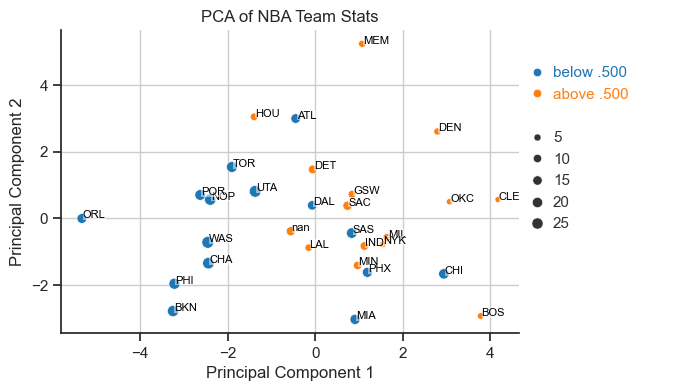

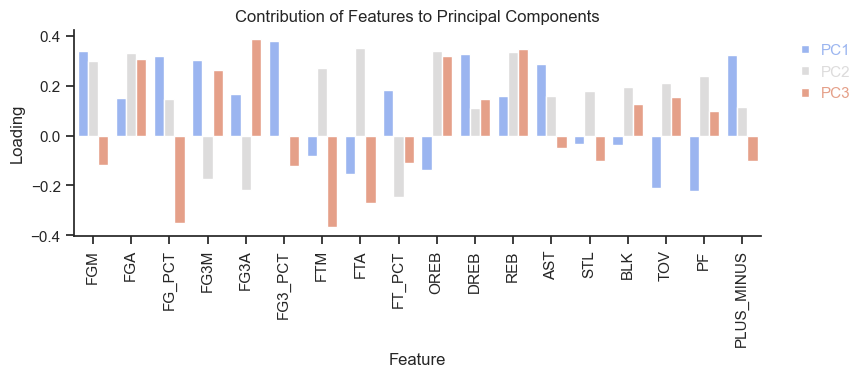

In [41]:
import seaborn as sns
season_df['team_abrev'] = season_df['TEAM_NAME'].map(team_mapping)

set_fig_style(
    figsize_mm=(150, 100),
    font_scale=1.0,
    style='ticks',
    context='notebook',
)

season_df ['WL_cat'] = season_df['WL_PCT'].apply(lambda x: 'above .500' if x>0.5 else 'below .500')

sns.scatterplot(data=season_df, x='PC1', y='PC2', hue = 'WL_cat', size = 'league_standing')
for i in range(len(season_df)):
    plt.text(x=season_df['PC1'][i] + 0.02,  # Offset text slightly to the right for clarity
             y=season_df['PC2'][i] + 0.01,  # Offset text slightly up for clarity
             s=season_df['team_abrev'][i],   # Team name as the text
             fontdict=dict(color='black', size=8),
             bbox=dict(facecolor='white', alpha=0.5, pad=0, edgecolor='none'))
    
sns.despine()
plt.title('PCA of NBA Team Stats')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.35, 1))
plt.show()

long_df = loading_df.reset_index().melt(id_vars='index', var_name='Component', value_name='Loading')
long_df.rename(columns={'index': 'Feature'}, inplace=True)

set_fig_style(
    figsize_mm=(200, 100),
    font_scale=1.0,
    style='ticks',
    context='notebook',
)

sns.barplot(data=long_df, x='Feature', y='Loading', hue='Component', palette='coolwarm')
sns.despine()
plt.title('Contribution of Features to Principal Components')
plt.xlabel('Feature')
plt.ylabel('Loading')
plt.xticks(rotation=90)  # Rotate feature names for better visibility
plt.legend(title='Component')
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.legend(bbox_to_anchor=(1.15, 1))

plt.show()

In [42]:
numeric_cols = ['FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
                'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
                'TOV', 'PF', 'PLUS_MINUS']


# Check for non-numeric data and convert
season_df[numeric_cols] = season_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Check and handle missing values
season_df[numeric_cols] = season_df[numeric_cols].fillna(season_df[numeric_cols].mean())

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(season_df[numeric_cols])
scaled_df = pd.DataFrame(data_scaled, columns=numeric_cols)

scaled_df['TEAM_NAME'] = season_df['TEAM_NAME'].values

scaled_df = scaled_df[['TEAM_NAME'] + numeric_cols]


In [43]:
numeric_cols = ['FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
                'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
                'TOV', 'PF', 'PLUS_MINUS']


# Check for non-numeric data and convert
games_df[numeric_cols] = games_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Check and handle missing values
games_df[numeric_cols] = games_df[numeric_cols].fillna(games_df[numeric_cols].mean())

scaler = StandardScaler()  # Standardizes each column (stat) across all teams
data_scaled = scaler.fit_transform(games_df[numeric_cols])  

# Convert back to DataFrame with original column names
scaled_df = pd.DataFrame(data_scaled, columns=numeric_cols)


scaled_df['TEAM_ABBREVIATION'] = games_df['TEAM_ABBREVIATION'].values
scaled_df['WL'] = games_df['WL'].values

scaled_df = scaled_df[['TEAM_ABBREVIATION'] + ['WL'] +numeric_cols]


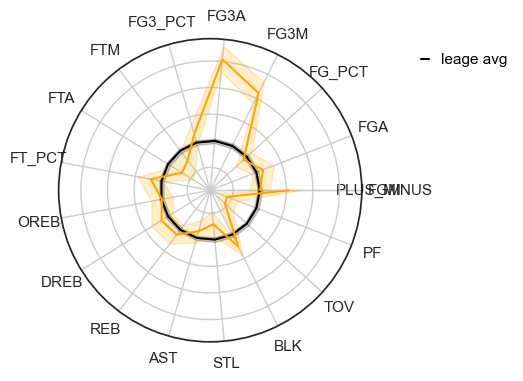

In [44]:
# need to change how data is normalized, sample for norm should be team avg not single games

numeric_cols = ['FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
                'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
                'TOV', 'PF', 'PLUS_MINUS']


# Check for non-numeric data and convert
games_df[numeric_cols] = games_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Check and handle missing values
games_df[numeric_cols] = games_df[numeric_cols].fillna(games_df[numeric_cols].mean())

scaler = StandardScaler()  # Standardizes each column (stat) across all teams
data_scaled = scaler.fit_transform(games_df[numeric_cols])  

# Convert back to DataFrame with original column names
scaled_df = pd.DataFrame(data_scaled, columns=numeric_cols)


scaled_df['TEAM_ABBREVIATION'] = games_df['TEAM_ABBREVIATION'].values
scaled_df['WL'] = games_df['WL'].values

scaled_df = scaled_df[['TEAM_ABBREVIATION'] + ['WL'] +numeric_cols]


long_df = scaled_df.melt(id_vars=['TEAM_ABBREVIATION','WL'], value_vars=numeric_cols, var_name='Stat', value_name='Value')

long_df['angle'] = np.linspace(0, 2 * np.pi, len(numeric_cols)).repeat(len(scaled_df))

set_fig_style(figsize_mm=(100,100))
# Create Polar Plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Scatterplot in Polar Coordinates

sns.lineplot(
    x="angle", 
    y="Value", 
    #hue="TEAM_NAME",  # Use TEAM_NAME as hue (optional)
    color="black",
    data=long_df,
    label = ['leage avg'],
    ax=ax
)

sns.lineplot(
    x="angle", 
    y="Value", 
    #style="WL",  # Use TEAM_NAME as hue (optional)
    color = "orange",
    data=long_df[long_df['TEAM_ABBREVIATION'] == 'BOS'],
    ax=ax
)

# sns.lineplot(
#     x="angle", 
#     y="Value", 
#     #hue="TEAM_NAME",  # Use TEAM_NAME as hue (optional)
#     color="yellow",
#     data=long_df[long_df['TEAM_ABBREVIATION'] == 'GSW'],
#     label = ['GSW'],
#     ax=ax
# )




# Set custom x-ticks (angles) to show original stat names
ax.set_xticks(np.linspace(0, 2 * np.pi, len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=45)
ax.set_yticklabels([])

ax.legend(loc='upper left', bbox_to_anchor=(1.15, 1))
plt.xlabel(None)
plt.ylabel(None)

ax.set_xticks(np.linspace(0, 2 * np.pi, len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=45)
plt.show()



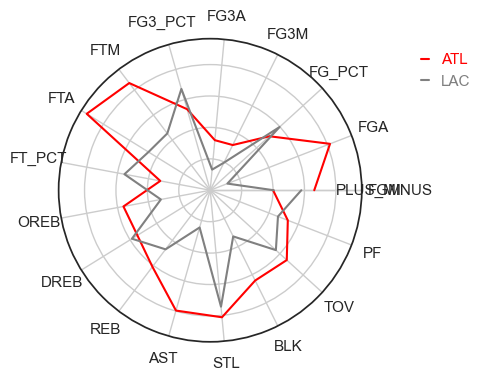

In [53]:
numeric_cols = ['FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
                'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
                'TOV', 'PF', 'PLUS_MINUS']


# Check for non-numeric data and convert
season_df[numeric_cols] = season_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Check and handle missing values
season_df[numeric_cols] = season_df[numeric_cols].fillna(season_df[numeric_cols].mean())


scaler = MinMaxScaler()  # Scales each column between 0 and 1
data_scaled = scaler.fit_transform(season_df[numeric_cols])

scaled_df = pd.DataFrame(data_scaled, columns=numeric_cols)
scaled_df['TEAM_NAME'] = season_df['TEAM_NAME'].values
scaled_df = scaled_df[['TEAM_NAME'] + numeric_cols]


scaled_df['TEAM_NAME'] = season_df['TEAM_NAME'].values


scaled_df = scaled_df[['TEAM_NAME'] + numeric_cols]


long_df = scaled_df.melt(id_vars=['TEAM_NAME'], value_vars=numeric_cols, var_name='Stat', value_name='Value')

long_df['angle'] = np.linspace(0, 2 * np.pi, len(numeric_cols)).repeat(len(scaled_df))

set_fig_style(figsize_mm=(100,100))
# Create Polar Plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Scatterplot in Polar Coordinates

# sns.lineplot(
#     x="angle", 
#     y="Value", 
#     #hue="TEAM_NAME",  # Use TEAM_NAME as hue (optional)
#     color="black",
#     data=long_df,
#     label = ['leage avg'],
#     ax=ax
# )

sns.lineplot(
    x="angle", 
    y="Value", 
    #hue="TEAM_NAME",  # Use TEAM_NAME as hue (optional)
    color="red",
    data=long_df[long_df['TEAM_NAME'] == 'Atlanta Hawks'],
    label = ['ATL'],
    ax=ax
)

sns.lineplot(
    x="angle", 
    y="Value", 
    #hue="TEAM_NAME",  # Use TEAM_NAME as hue (optional)
    color="grey",
    data=long_df[long_df['TEAM_NAME'] == 'LA Clippers'],
    label = ['LAC'],
    ax=ax
)




# Set custom x-ticks (angles) to show original stat names
ax.set_xticks(np.linspace(0, 2 * np.pi, len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=45)
ax.set_yticklabels([])

ax.legend(loc='upper left', bbox_to_anchor=(1.15, 1))
plt.xlabel(None)
plt.ylabel(None)

ax.set_xticks(np.linspace(0, 2 * np.pi, len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=45)
plt.show()



In [129]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def NBA_games_linear_regression(df: pd.DataFrame = games_df, team_abbreviation: str = 'BOS',
                                predictors: list = ['FGA', 'FGM'], response: str = 'PTS'):
    """
    Performs linear regression on NBA games data to predict the response variable based on given predictors.

    Parameters:
    df (pd.DataFrame): DataFrame containing NBA games data with required columns.
    team_abbreviation (str): Abbreviation of the team for which the model is to be fitted.
    predictors (list): List of column names in df to be used as predictors in the model.
    response (str): The column name in df which is to be used as the response variable.

    Returns:
    tuple: A tuple containing two elements:
        - pd.DataFrame: A DataFrame with actual and predicted values of the response variable along with one of the predictors for plotting.
        - float: R-squared value indicating the goodness of fit of the model.

    Raises:
    TypeError: If 'df' is not a pandas DataFrame, or 'team_abbreviation', 'predictors', or 'response' are not of expected type.
    ValueError: If 'team_abbreviation' not in DataFrame, or 'predictors' or 'response' columns are not in DataFrame.
                 If any of the predictor or response columns contain non-numeric data.
    """

    # Validate input types
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Expected 'df' to be a pandas DataFrame.")
    if not isinstance(team_abbreviation, str):
        raise TypeError("Expected 'team_abbreviation' to be a string.")
    if not isinstance(predictors, list) or not all(isinstance(item, str) for item in predictors):
        raise TypeError("Expected 'predictors' to be a list of strings.")
    if not isinstance(response, str):
        raise TypeError("Expected 'response' to be a string.")

    # Validate input values
    if team_abbreviation not in df['TEAM_ABBREVIATION'].unique():
        raise ValueError(f"Team abbreviation '{team_abbreviation}' not found in DataFrame.")
    if any(col not in df.columns for col in predictors):
        raise ValueError("Some predictors are not present in DataFrame.")
    if response not in df.columns:
        raise ValueError(f"Response column '{response}' is not present in DataFrame.")

    # Check if columns are numeric
    for col in predictors + [response]:
        if not pd.api.types.is_numeric_dtype(df[col]):
            raise ValueError(f"Column '{col}' must be numeric for linear regression.")

    # Proceed with the regression analysis
    X = df[df['TEAM_ABBREVIATION'] == team_abbreviation][predictors].values  # Multiple predictors
    y = df[df['TEAM_ABBREVIATION'] == team_abbreviation][response].values  # Response

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

    # Create and train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict on the testing set
    y_pred = model.predict(X_test)

    # Calculate R-squared
    r2 = r2_score(y_test, y_pred)

    # Prepare the DataFrame for visualization
    actual_scores = pd.DataFrame({
        'FGM': X_test[:, 1],  # Second predictor
        'PTS': y_test,
        'Type': 'Actual'
    })
    predicted_scores = pd.DataFrame({
        'FGM': X_test[:, 1],  # We plot against FGM for consistency
        'PTS': y_pred,
        'Type': 'Predicted'
    })

    # Combine actual and predicted scores into one DataFrame
    linear_regression_df = pd.concat([actual_scores, predicted_scores])
    
    return linear_regression_df, r2


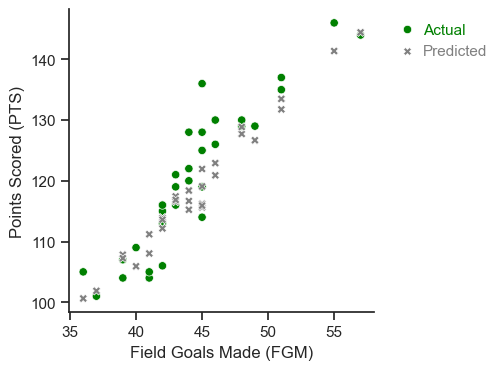

In [131]:
linear_regressoion_df, r2 = NBA_games_linear_regression(df = games_df,team_abbreviation = 'OKC',\
                                                        predictors = ['FGA','FGM'],response = 'PTS')

# Plotting
set_fig_style(figsize_mm=(100,100))
sns.scatterplot(data=linear_regressoion_df, x='FGM', y='PTS', hue='Type', style='Type', palette=['green', 'grey'])
sns.despine()
plt.legend(loc='upper left',bbox_to_anchor=(1.05, 1))
plt.xlabel('Field Goals Made (FGM)')
plt.ylabel('Points Scored (PTS)')

plt.show()

In [197]:

def NBA_games_logistic_regression(df: pd.DataFrame = games_df, team_abbreviation: str = 'BOS',
                                  predictors: list = ['FGA', 'FGM'], response: str = 'WL'):
    """
    Performs logistic regression on NBA games data to classify the response variable based on given predictors.

    Parameters:
    df (pd.DataFrame): DataFrame containing NBA games data with required columns.
    team_abbreviation (str): Abbreviation of the team for which the model is to be fitted.
    predictors (list): List of column names in df to be used as predictors in the model.
    response (str): The column name in df which is to be used as the binary response variable (e.g., 'WIN_LOSE' column with values 0 for loss and 1 for win).

    Returns:
    tuple: A tuple containing three elements:
        - pd.DataFrame: A DataFrame with actual and predicted values of the response variable along with one of the predictors for plotting.
        - float: Accuracy of the model.
        - pd.DataFrame: Confusion matrix of the model predictions.

    Raises:
    TypeError: If 'df' is not a pandas DataFrame, or 'team_abbreviation', 'predictors', or 'response' are not of expected type.
    ValueError: If 'team_abbreviation' not in DataFrame, or 'predictors' or 'response' columns are not in DataFrame.
                 If any of the predictor or response columns contain non-numeric data.
                 If the response column is not binary.
    """

    # Validate input types
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Expected 'df' to be a pandas DataFrame.")
    if not isinstance(team_abbreviation, str):
        raise TypeError("Expected 'team_abbreviation' to be a string.")
    if not isinstance(predictors, list) or not all(isinstance(item, str) for item in predictors):
        raise TypeError("Expected 'predictors' to be a list of strings.")
    if not isinstance(response, str):
        raise TypeError("Expected 'response' to be a string.")

    # Validate input values
    if team_abbreviation not in df['TEAM_ABBREVIATION'].unique():
        raise ValueError(f"Team abbreviation '{team_abbreviation}' not found in DataFrame.")
    if any(col not in df.columns for col in predictors):
        raise ValueError("Some predictors are not present in DataFrame.")
    if response not in df.columns:
        raise ValueError(f"Response column '{response}' is not present in DataFrame.")

    # Check if columns are numeric
    for col in predictors:
        if not pd.api.types.is_numeric_dtype(df[col]):
            raise ValueError(f"Predictor column '{col}' must be numeric for logistic regression.")

    if df[response].nunique() != 2:
        raise ValueError(f"Response column '{response}' must be binary (contain exactly two unique values).")

    # Proceed with the logistic regression analysis
    X = df[df['TEAM_ABBREVIATION'] == team_abbreviation][predictors].values
    y = df[df['TEAM_ABBREVIATION'] == team_abbreviation][response].values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

    # Create and train the logistic regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Predict on the testing set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Prepare the DataFrame for visualization
    results_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    })

    # Prepare confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    return results_df, accuracy, pd.DataFrame(conf_matrix, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])


model accuracy: 0.875


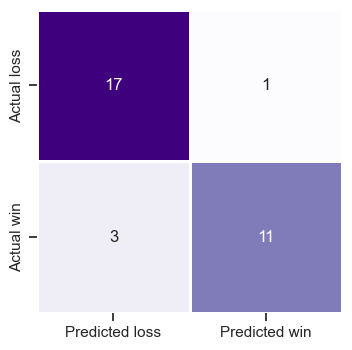

In [254]:
result_df,accuracy,conf_mat = NBA_games_logistic_regression(df = games_df, team_abbreviation = 'CHI',\
                                                            predictors = ['PTS','REB','AST'],
                                                            response = 'WL' )
print(f'model accuracy: {accuracy}')
conf_mat = conf_mat.rename(index = {'Actual 0' : 'Actual loss','Actual 1' : 'Actual win'})
conf_mat = conf_mat.rename(columns = {'Predicted 0' : 'Predicted loss','Predicted 1' : 'Predicted win'})


sns.heatmap(data=conf_mat, annot=True, fmt='d', cmap='Purples',linewidth = 1.0, cbar = False)
plt.show()

In [372]:
mat = np.random.randint(1,10,size = (2,2))
mat

array([[1, 9],
       [5, 1]])

In [390]:
col_mean = np.mean(mat, axis=1).T
col_std = np.std(mat,axis=1).T
mat_scaled = (mat-col_mean)/col_std
print(f'column mean = {col_mean}')
print(f'column std = {col_std}')
print(f'matrix scaled = {mat_scaled}')


column mean = [5. 3.]
column std = [4. 2.]
matrix scaled = [[-1.  3.]
 [ 0. -1.]]


4

In [400]:
cov_mat = (1/(np.size(mat)-1))*(mat_scaled.T*mat_scaled)
print(f'covariance matrix = {cov_mat}')

covariance matrix = [[0.33333333 0.        ]
 [0.         0.33333333]]


In [ ]:
eigenvector = 0.3*eigenvalue